In [1]:
import pandas as pd
import numpy as np
import os, math, time, json, csv, random
from collections import defaultdict

from PIL import Image, ImageOps, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score
import itertools

import matplotlib.pyplot as plt
from tqdm import tqdm

PROJ_ROOT = "/home/shoo/personal/dlDev/school/classificationProject"
META_DIR  = f"{PROJ_ROOT}/meta"
DATA_DIR  = f"{PROJ_ROOT}/data"
CROPS_DIR = f"{PROJ_ROOT}/crops"

LOG_DIR  = os.path.join(PROJ_ROOT, "logs")
MODEL_DIR = os.path.join(PROJ_ROOT, "model")
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

MANIFEST_PATH   = f"{META_DIR}/manifest.csv"
CLASSES_JSON    = f"{META_DIR}/classes.json"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

NUM_CLASSES = 10

SEED = 42

Device: cuda


In [2]:
def seed_everything(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Deterministic kernels (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # If you need *strict* determinism (may error on some ops):
    # torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    # Make each worker deterministic (NumPy / Python RNG too)
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

seed_everything(SEED)

In [3]:
with open(CLASSES_JSON, "r") as f:
    classes_meta = json.load(f)

# Expecting a "classes" list with fields: id, name, display_name, ...
name_to_id = {c["name"]: c["id"] for c in classes_meta["classes"]}
id_to_name = {c["id"]: c["name"] for c in classes_meta["classes"]}
index_order = classes_meta.get("index_order", [c["name"] for c in classes_meta["classes"]])

print("Classes (name -> id):", name_to_id)

Classes (name -> id): {'car': 0, 'truck': 1, 'bus': 2, 'trailer': 3, 'construction_vehicle': 4, 'pedestrian': 5, 'motorcycle': 6, 'bicycle': 7, 'traffic_cone': 8, 'barrier': 9}


In [4]:
df = pd.read_csv(MANIFEST_PATH)
IOU_THR = 0.60
IOA_THR = 0.60

clean_df = df.query("max_cross_iou < @IOU_THR and max_cross_ioa < @IOA_THR").reset_index(drop=True)

print("Kept rows:", len(clean_df), "of", len(df), " | -", len(df)-len(clean_df))
print(clean_df["class"].value_counts(dropna=False))


Kept rows: 163739 of 172178  | - 8439
class
car                     81346
barrier                 18540
truck                   16709
pedestrian              15299
traffic_cone             8172
bicycle                  7110
motorcycle               7101
bus                      3628
construction_vehicle     3601
trailer                  2233
Name: count, dtype: int64


In [5]:

# Majority (primary) class per image, to stratify at image level
img_class_counts = (clean_df.groupby(["img_path","class"])
                    .size().reset_index(name="n"))
major = (img_class_counts.sort_values(["img_path","n"], ascending=[True, False])
                      .drop_duplicates("img_path"))
img2label = dict(zip(major["img_path"], major["class"]))

groups = clean_df["img_path"].values
y_img  = clean_df["img_path"].map(img2label).values

def stratified_group_split70_15_15(df, y=None, groups=None, seed=42):
    """
    Leak-proof 70/15/15 split:
      - one row per unique img_path (primary/majority class per image)
      - stratify on image-level primary class
      - map image splits back to crop rows
    """
    # 1) Image-level table with primary label
    img_tab = (df.groupby(['img_path','class'])
                 .size().reset_index(name='n')
                 .sort_values(['img_path','n'], ascending=[True, False])
                 .drop_duplicates('img_path'))
    imgs = img_tab['img_path'].values
    yimg = img_tab['class'].values

    # 2) Train 70% vs Temp 30% (stratified by image primary class)
    imgs_train, imgs_temp, y_train, y_temp = train_test_split(
        imgs, yimg, train_size=0.70, random_state=seed, stratify=yimg
    )

    # 3) Temp → Val/Test 50/50 (≈15/15 overall), stratified
    imgs_val, imgs_test, y_val, y_test = train_test_split(
        imgs_temp, y_temp, train_size=0.50, random_state=seed, stratify=y_temp
    )

    # 4) Map back to crop rows
    s_train, s_val, s_test = set(imgs_train), set(imgs_val), set(imgs_test)
    train_df = df[df['img_path'].isin(s_train)].reset_index(drop=True)
    val_df   = df[df['img_path'].isin(s_val)].reset_index(drop=True)
    test_df  = df[df['img_path'].isin(s_test)].reset_index(drop=True)

    # 5) Sanity: zero leakage
    a, b, c = set(train_df['img_path']), set(val_df['img_path']), set(test_df['img_path'])
    assert len(a & b) == 0 and len(a & c) == 0 and len(b & c) == 0, "Leakage across splits!"

    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_group_split70_15_15(clean_df, y_img, groups, seed=SEED)

def _summary(df, name):
    print(f"{name:5s} rows={len(df):6d}  images={df['img_path'].nunique():5d}")
    print(df["class"].value_counts(dropna=False),"\n")

def leakage_ok(train_df, val_df, test_df):
    a, b, c = set(train_df['img_path']), set(val_df['img_path']), set(test_df['img_path'])
    print("train∩val:", len(a & b), "  train∩test:", len(a & c), "  val∩test:", len(b & c))

_summary(train_df, "train")
_summary(val_df,   "val")
_summary(test_df,  "test")
leakage_ok(train_df, val_df, test_df)  # should all be 0


train rows=114965  images=39745
class
car                     57174
barrier                 12921
truck                   11722
pedestrian              10868
traffic_cone             5715
motorcycle               4998
bicycle                  4987
bus                      2535
construction_vehicle     2506
trailer                  1539
Name: count, dtype: int64 

val   rows= 24335  images= 8517
class
car                     12012
barrier                  2843
truck                    2479
pedestrian               2203
traffic_cone             1240
bicycle                  1051
motorcycle               1051
construction_vehicle      562
bus                       561
trailer                   333
Name: count, dtype: int64 

test  rows= 24439  images= 8517
class
car                     12160
barrier                  2776
truck                    2508
pedestrian               2228
traffic_cone             1217
bicycle                  1072
motorcycle               1052
construction_vehicle

In [6]:
def attach_abs_paths(df):
    """
    Resolve df['crop_path'] -> df['__abs_path__'] for a local project layout:
      - Absolute paths or '~' are kept/expanded.
      - 'crops/…'  ->  <CROPS_DIR>/…
      - 'data/crops/…' -> <DATA_DIR>/crops/…
      - else assume it's relative to <CROPS_DIR> (e.g., 'car/xxx.jpg').
    Returns: filtered DataFrame with only existing files.
    """
    assert os.path.exists(CROPS_DIR), f"CROPS_DIR not found: {CROPS_DIR}"
    assert os.path.exists(DATA_DIR),  f"DATA_DIR not found:  {DATA_DIR}"

    def resolve(p):
        p = str(p).strip().lstrip("./")
        # absolute / home-expanded
        if p.startswith("~"):
            return os.path.expanduser(p)
        if os.path.isabs(p):
            return p

        # manifest patterns
        if p.startswith("crops/"):
            return os.path.join(CROPS_DIR, p.split("crops/", 1)[1])

        if p.startswith("data/crops/"):
            # normalize in case someone left 'data/crops/' in the CSV
            return os.path.join(DATA_DIR, "crops", p.split("data/crops/", 1)[1])

        # default: treat as relative to crops root
        return os.path.join(CROPS_DIR, p)

    out = df.copy()
    out["__abs_path__"] = out["crop_path"].apply(resolve)
    # normalize paths (remove duplicate slashes, resolve '..', symlinks ok)
    out["__abs_path__"] = out["__abs_path__"].apply(lambda x: str(Path(x).resolve(strict=False)))

    mask = out["__abs_path__"].apply(os.path.exists)
    missing = int((~mask).sum())
    if missing:
        print(f"[warn] {missing} crop files are missing; skipped.")
        # Uncomment to inspect examples:
        # print(out.loc[~mask, ["crop_path","__abs_path__"]].head(6).to_string(index=False))
    return out[mask].reset_index(drop=True)

class Letterbox224:
    """
    Resize preserving aspect ratio and pad to 224x224.
    - Uses high-quality BICUBIC upsampling for small crops.
    - Pads with black (0) by default (works fine with ImageNet normalization later).
    """
    def __init__(self, size=224, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        if w == 0 or h == 0:
            # create a dummy black image to avoid crashes
            return Image.new("RGB", (self.size, self.size), self.fill)

        scale = min(self.size / w, self.size / h)  # fit within square
        nw, nh = max(1, int(round(w * scale))), max(1, int(round(h * scale)))
        # Resize with antialiasing (BICUBIC is good for upscaling small crops)
        img = img.resize((nw, nh), Image.BICUBIC)

        # pad to square canvas
        new_im = Image.new("RGB", (self.size, self.size), self.fill)
        left = (self.size - nw) // 2
        top  = (self.size - nh) // 2
        new_im.paste(img, (left, top))
        return new_im

def collate_skip_none(batch):
    """Drop samples that failed to load/transform."""
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    xs, ys = zip(*batch)
    return torch.stack(xs, 0), torch.tensor(ys)

In [7]:
train_df_ = attach_abs_paths(train_df)
val_df_   = attach_abs_paths(val_df)
test_df_  = attach_abs_paths(test_df)

letterbox = Letterbox224(224, fill=0)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    letterbox,
    # ADDED BY ROBIN
    transforms.RandomHorizontalFlip(p=0.5),      # Horizontal flip 0.5
    transforms.RandomVerticalFlip(p=0.5),        # Vertical flip 0.5
    transforms.RandomRotation(degrees=36),       # Rotate 0.2 * 180 = 36 degrees
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),  # Random zoom 0.2 (0.8 to 1.2x)
    # END
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    letterbox,
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [8]:
class NuCropsDataset(Dataset):
    def __init__(self, frame, label_map, transform, report_small=True, small_thresh=12):
        self.df = frame.reset_index(drop=True)
        self.lm = label_map
        self.t  = transform
        self.report_small = report_small
        self.small_thresh = small_thresh
        self._small_seen = 0

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        path = r["__abs_path__"]
        y = self.lm[r["class"]]
        try:
            with Image.open(path) as im:
                im = im.convert("RGB")
                # (Optional) tiny-crop counter (no performance penalty)
                if self.report_small:
                    w, h = im.size
                    if w < self.small_thresh or h < self.small_thresh:
                        self._small_seen += 1
                x = self.t(im) if self.t else im
        except Exception as e:
            # Skip unreadable images without crashing the batch
            # print(f"[read-fail] {path}: {e}")
            return None
        return x, y

train_ds = NuCropsDataset(train_df_, label_map=name_to_id, transform=train_tfms)
val_ds   = NuCropsDataset(val_df_,   label_map=name_to_id, transform=eval_tfms, report_small=False)
test_ds  = NuCropsDataset(test_df_,  label_map=name_to_id, transform=eval_tfms, report_small=False)

In [ ]:
BATCH = 64
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH,
    shuffle=True,                 # reproducible because we seed + pass generator
    num_workers=6,
    pin_memory=True,
    collate_fn=collate_skip_none,
    worker_init_fn=seed_worker,
    generator=g,                  # <-- important
    persistent_workers=False,     # keep False for simplest determinism
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH, shuffle=False, num_workers=6,
    pin_memory=True, collate_fn=collate_skip_none,
    worker_init_fn=seed_worker, generator=g
)

test_loader = DataLoader(
    test_ds, batch_size=BATCH, shuffle=False, num_workers=8,
    pin_memory=True, collate_fn=collate_skip_none,
    worker_init_fn=seed_worker, generator=g
)

In [10]:
def accuracy_top1(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")


In [11]:
def effective_number_weights(train_labels_idx, num_classes, beta=0.999, normalize_mean_to_1=True, clip=None):
    """
    Returns per-class weights w (numpy array length C) and per-class counts.
    train_labels_idx: list/array of integer class ids from TRAIN SET ONLY
    """
    counts = np.bincount(np.array(train_labels_idx, dtype=np.int64), minlength=num_classes).astype(float)
    eff_num = (1.0 - np.power(beta, counts)) / (1.0 - beta)
    w = 1.0 / np.clip(eff_num, 1e-8, None)
    if normalize_mean_to_1 and w.sum() > 0:
        w = w * (len(w) / w.sum())
    if clip is not None:
        w = np.clip(w, clip[0], clip[1])
    return w, counts

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is not None and not torch.is_tensor(alpha):
            alpha = torch.tensor(alpha, dtype=torch.float32)
        self.register_buffer("alpha", alpha if alpha is not None else None)

    def forward(self, logits, target):
        # Cross-entropy per-sample with optional per-class weight alpha
        ce = F.cross_entropy(logits, target, reduction="none", weight=self.alpha)
        pt = torch.exp(-ce)                 # pt = softmax prob of true class
        fl = (1 - pt) ** self.gamma * ce
        if self.reduction == "mean":
            return fl.mean()
        elif self.reduction == "sum":
            return fl.sum()
        return fl

In [ ]:
# ==== CSV logger ====
class CSVLogger:
    def __init__(self, filepath, epoch_base=0):
        self.filepath = filepath
        self.epoch_base = int(epoch_base)
        init_needed = not os.path.exists(filepath)
        if init_needed:
            import csv
            with open(self.filepath, "w", newline="") as f:
                w = csv.writer(f)
                w.writerow(["stage","epoch","cum_epoch","train_loss","train_acc","train_macro_f1",
                            "val_loss","val_acc","val_macro_f1","lr"])

    def log(self, stage, local_epoch, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1, lr):
        row = [stage, local_epoch, self.epoch_base + local_epoch,
               tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1, lr]
        import csv
        with open(self.filepath, "a", newline="") as f:
            csv.writer(f).writerow(row)


# ==== Plot helper ====
def plot_curves(csv_path, title="Train/Val Loss & Accuracy"):
    df = pd.read_csv(csv_path)
    x = df["cum_epoch"] if "cum_epoch" in df.columns else df["epoch"]
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(11,4))
    axes[0].plot(x, df["train_loss"], label="train")
    axes[0].plot(x, df["val_loss"],   label="val")
    axes[0].set_title("Loss"); axes[0].set_xlabel("epoch"); axes[0].legend(); axes[0].grid(True, ls="--", alpha=0.4)
    axes[1].plot(x, df["train_acc"], label="train acc")
    axes[1].plot(x, df["val_acc"],   label="val acc")
    axes[1].set_title("Accuracy"); axes[1].set_xlabel("epoch"); axes[1].legend(); axes[1].grid(True, ls="--", alpha=0.4)
    plt.suptitle(title); plt.tight_layout(); plt.show()


In [13]:
# ==== Model: ResNet-50 backbone + GAP + 3 hidden layers ====
def build_resnet50_headed(num_classes=10, hidden=(1024, 512, 256), dropout=0.25, pretrained=True):
    backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
    in_feats = backbone.fc.in_features  # 2048
    layers = []
    last = in_feats
    for h in hidden:
        layers += [nn.Linear(last, h), nn.BatchNorm1d(h), nn.ReLU(inplace=True), nn.Dropout(p=dropout)]
        last = h
    layers += [nn.Linear(last, num_classes)]
    backbone.fc = nn.Sequential(*layers)
    return backbone

# ==== Stage helpers ====
def set_trainable(mod, flag: bool):
    for p in mod.parameters():
        p.requires_grad = flag

def stage_A_freeze_backbone(model):  # freeze all except head
    set_trainable(model, False)
    set_trainable(model.fc, True)    # head only
    model.eval()                     # keep BN in backbone steady
    model.fc.train()

def stage_B_unfreeze_last_block(model):  # unfreeze layer4 + head
    set_trainable(model.layer1, False)
    set_trainable(model.layer2, False)
    set_trainable(model.layer3, False)
    set_trainable(model.layer4, True)
    set_trainable(model.fc, True)
    model.train()


In [ ]:
# ==== One epoch ====
def run_epoch(model, loader, criterion, optimizer=None, device=DEVICE, desc="train"):
    train_mode = optimizer is not None
    model.train(train_mode)

    losses = []
    y_true, y_pred = [], []

    pbar = tqdm(loader, desc=desc, leave=False)
    for xb, yb in pbar:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = criterion(logits, yb)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        with torch.no_grad():
            pred = logits.argmax(1)
        losses.append(loss.item())
        y_true.append(yb.detach().cpu())
        y_pred.append(pred.detach().cpu())

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    avg_loss = float(np.mean(losses)) if losses else float("nan")
    acc = accuracy_top1(y_true, y_pred)
    mf1 = macro_f1(y_true, y_pred)
    return avg_loss, acc, mf1

# ==== Stage trainer ====
def train_stage(stage_name, model, train_loader, val_loader, criterion, optimizer, scheduler,
                epochs, log_csv, best_ckpt_path, epoch_base=0, device=DEVICE):
    logger = CSVLogger(log_csv, epoch_base=epoch_base)
    best_f1 = -1.0

    for local_epoch in range(1, epochs+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, criterion, optimizer, device, desc=f"{stage_name} | train {local_epoch}/{epochs}")
        va_loss, va_acc, va_f1 = run_epoch(model, val_loader,   criterion, None,      device, desc=f"{stage_name} | val   {local_epoch}/{epochs}")

        if scheduler is not None:
            scheduler.step(va_loss)

        current_lr = next(iter(optimizer.param_groups))["lr"]
        logger.log(stage_name, local_epoch, tr_loss, tr_acc, tr_f1, va_loss, va_acc, va_f1, current_lr)

        if va_f1 > best_f1:
            best_f1 = va_f1
            torch.save({"model": model.state_dict(), "stage": stage_name, "epoch": local_epoch, "val_macro_f1": va_f1}, best_ckpt_path)
            print(f"[{stage_name}] epoch {local_epoch}: new BEST macro-F1={va_f1:.4f} (saved)")

    # return where we ended to be the base for the next stage
    return epoch_base + epochs, best_f1


In [ ]:
# ==== Stage A setup ====
NUM_CLASSES = len(name_to_id)

# collect train labels as ids for weighting
train_labels_idx = [name_to_id[c] for c in train_ds.df["class"].tolist()]

# class weights (simple inverse-frequency, normalized mean≈1, clipped)
counts = np.bincount(np.array(train_labels_idx), minlength=NUM_CLASSES).astype(float)
inv = 1.0 / np.clip(counts, 1, None)
w = inv * (len(inv) / inv.sum())
w = np.clip(w, 0.25, 4.0)
print("Stage A class weights (inv-freq, normed):", np.round(w, 3).tolist())

criterion_A = nn.CrossEntropyLoss(weight=torch.tensor(w, dtype=torch.float32).to(DEVICE))

model = build_resnet50_headed(num_classes=NUM_CLASSES, hidden=(1024, 512, 256), dropout=0.25, pretrained=True).to(DEVICE)
stage_A_freeze_backbone(model)

# optimizer: head params only (backbone frozen)
head_params = [p for p in model.fc.parameters() if p.requires_grad]
optimizer_A = torch.optim.AdamW(head_params, lr=5e-4, weight_decay=0.01)
scheduler_A = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_A, mode="min", patience=5, factor=0.5, min_lr=1e-6)

LOG_CSV = os.path.join(LOG_DIR, "train_log.csv")
BEST_CKPT = os.path.join(MODEL_DIR, "best.pth")  # overwritten by later stages if they win

epoch_base, best_f1_A = train_stage("StageA", model, train_loader, val_loader,
                                    criterion_A, optimizer_A, scheduler_A,
                                    epochs=10, log_csv=LOG_CSV, best_ckpt_path=BEST_CKPT,
                                    epoch_base=0, device=DEVICE)
print(f"Stage A best macro-F1: {best_f1_A:.4f}")


Stage A class weights (inv-freq, normed): [0.25, 0.372, 1.722, 2.836, 1.742, 0.402, 0.873, 0.875, 0.764, 0.338]


[StageA] epoch 1: new BEST macro-F1=0.6827  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageA] epoch 2: new BEST macro-F1=0.7187  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageA] epoch 3: new BEST macro-F1=0.7276  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageA] epoch 6: new BEST macro-F1=0.7464  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageA] epoch 9: new BEST macro-F1=0.7492  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


Stage A best macro-F1: 0.7492


In [ ]:
# ==== Stage B setup ====
# derive alpha from effective number of samples (train only)
alpha_np, class_counts = effective_number_weights(train_labels_idx, num_classes=NUM_CLASSES, beta=0.999, normalize_mean_to_1=True, clip=None)
print("Stage B alpha (effective-number, mean≈1):", np.round(alpha_np, 3).tolist())
criterion_B = FocalLoss(alpha=torch.tensor(alpha_np, dtype=torch.float32).to(DEVICE), gamma=2.0, reduction="mean")

# unfreeze last block + head; make optimizer with param groups (smaller LR on layer4)
stage_B_unfreeze_last_block(model)

params = [
    {"params": [p for n,p in model.layer4.named_parameters() if p.requires_grad], "lr": 1e-4, "weight_decay": 0.01},
    {"params": [p for p in model.fc.parameters() if p.requires_grad],             "lr": 5e-4, "weight_decay": 0.01},
]
optimizer_B = torch.optim.AdamW(params)
scheduler_B = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_B, mode="min", patience=5, factor=0.5, min_lr=1e-6)

epoch_base, best_f1_B = train_stage("StageB", model, train_loader, val_loader,
                                    criterion_B, optimizer_B, scheduler_B,
                                    epochs=40, log_csv=LOG_CSV, best_ckpt_path=BEST_CKPT,
                                    epoch_base=epoch_base, device=DEVICE)
print(f"Stage B best macro-F1: {best_f1_B:.4f}")


Stage B alpha (effective-number, mean≈1): [0.956, 0.956, 1.038, 1.216, 1.04, 0.956, 0.962, 0.962, 0.959, 0.956]


[StageB] epoch 1: new BEST macro-F1=0.8396  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 2: new BEST macro-F1=0.8617  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 3: new BEST macro-F1=0.8648  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 4: new BEST macro-F1=0.8723  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 5: new BEST macro-F1=0.8827  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 6: new BEST macro-F1=0.8846  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 7: new BEST macro-F1=0.8876  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 8: new BEST macro-F1=0.8881  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 9: new BEST macro-F1=0.8887  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 10: new BEST macro-F1=0.8901  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 12: new BEST macro-F1=0.8984  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 18: new BEST macro-F1=0.9048  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 24: new BEST macro-F1=0.9055  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 25: new BEST macro-F1=0.9081  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 26: new BEST macro-F1=0.9084  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 30: new BEST macro-F1=0.9101  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 32: new BEST macro-F1=0.9112  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 39: new BEST macro-F1=0.9116  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)


[StageB] epoch 40: new BEST macro-F1=0.9125  (saved → /home/shoo/personal/dlDev/school/classificationProject/model/best.pth)
Stage B best macro-F1: 0.9125


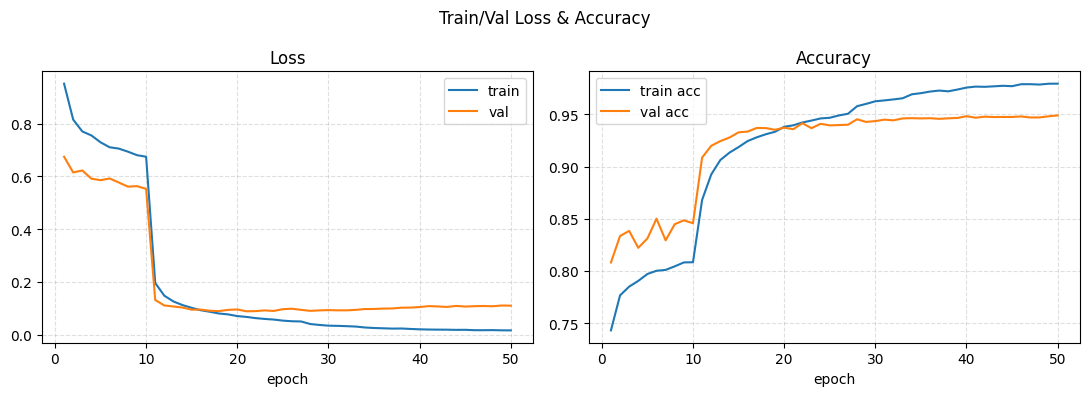

[TEST] loss=0.1053  acc=0.9466  macro-F1=0.9097


In [19]:
# ==== Curves ====
plot_curves(LOG_CSV, title="Train/Val Loss & Accuracy")

# ==== (Optional) Evaluate best checkpoint on test ====
best = torch.load(BEST_CKPT, map_location=DEVICE)
model.load_state_dict(best["model"])
test_loss, test_acc, test_f1 = run_epoch(model, test_loader, criterion_B, optimizer=None, device=DEVICE, desc="TEST")
print(f"[TEST] loss={test_loss:.4f}  acc={test_acc:.4f}  macro-F1={test_f1:.4f}")



== TEST classification report ==
                      precision    recall  f1-score   support

                 car      0.961     0.972     0.967     12160
               truck      0.820     0.826     0.823      2508
                 bus      0.889     0.816     0.851       532
             trailer      0.805     0.684     0.740       361
construction_vehicle      0.912     0.839     0.874       533
          pedestrian      0.973     0.979     0.976      2228
          motorcycle      0.949     0.928     0.938      1052
             bicycle      0.963     0.962     0.962      1072
        traffic_cone      0.988     0.976     0.982      1217
             barrier      0.983     0.986     0.985      2776

            accuracy                          0.947     24439
           macro avg      0.924     0.897     0.910     24439
        weighted avg      0.946     0.947     0.946     24439



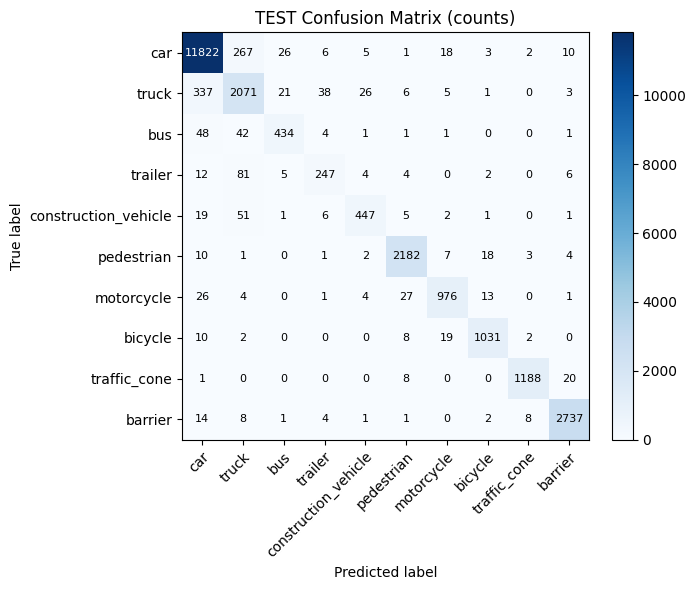

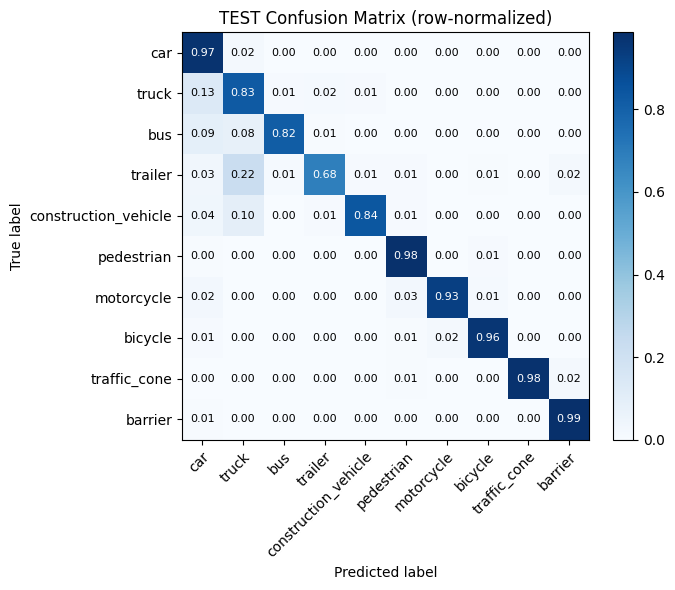

Top TEST confusions (count):
truck                  → car                    : 337
car                    → truck                  : 267
trailer                → truck                  : 81
construction_vehicle   → truck                  : 51
bus                    → car                    : 48
bus                    → truck                  : 42
truck                  → trailer                : 38
motorcycle             → pedestrian             : 27
car                    → bus                    : 26
truck                  → construction_vehicle   : 26
Top TEST confusions (row-normalized):
trailer                → truck                  : 0.224  (81 samples)
truck                  → car                    : 0.134  (337 samples)
construction_vehicle   → truck                  : 0.096  (51 samples)
bus                    → car                    : 0.090  (48 samples)
bus                    → truck                  : 0.079  (42 samples)
construction_vehicle   → car                    : 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# id ↔ name maps
id_to_name = {v:k for k,v in name_to_id.items()}
class_names = [id_to_name[i] for i in range(len(id_to_name))]

@torch.no_grad()
def collect_preds(model, loader, device):
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(1)
        ys.append(yb.cpu().numpy())
        ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return y_true, y_pred

def plot_confmat(cm, labels, title="Confusion matrix", normalize=False, figsize=(7.5,6.0)):
    if normalize:
        # row-normalize (per true class)
        with np.errstate(all='ignore'):
            cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(len(labels)),
           yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels,
           ylabel="True label", xlabel="Predicted label",
           title=title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # overlay values for readability (sparse for large matrices)
    thresh = cm.max() * 0.6
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            txt = f"{val:.2f}" if normalize else (str(int(val)) if val.is_integer() else f"{val:.1f}")
            if cm.shape[0] <= 12:  # avoid clutter for large C
                ax.text(j, i, txt, ha="center", va="center",
                        color="white" if val > thresh else "black", fontsize=8)
    fig.tight_layout()
    plt.show()

def top_confusions(cm, labels, k=8):
    """Return the top off-diagonal confusions (true->pred) by count."""
    c = cm.copy()
    np.fill_diagonal(c, 0)
    pairs = []
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if c[i, j] > 0:
                pairs.append((int(c[i, j]), labels[i], labels[j]))
    pairs.sort(reverse=True, key=lambda x: x[0])
    return pairs[:k]

import numpy as np

def top_confusions_norm(cm, labels, k=10):
    """
    Return the top off-diagonal confusions ranked by row-normalized value.
    Each item: (ratio, count, true_label, pred_label)
    """
    cm = np.asarray(cm, dtype=float)
    row_sum = cm.sum(axis=1, keepdims=True)
    rn = np.divide(cm, row_sum, out=np.zeros_like(cm), where=row_sum>0)  # row-normalized
    c = rn.copy()
    np.fill_diagonal(c, 0.0)

    out = []
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if i == j or cm[i, j] == 0:
                continue
            out.append((c[i, j], int(cm[i, j]), labels[i], labels[j]))

    # sort by ratio desc, then count desc to break ties
    out.sort(key=lambda x: (x[0], x[1]), reverse=True)
    return out[:k]

def top_confusions_by_class(cm, labels, topn=3):
    """
    For each true class, return its top-N mistaken predictions by row-normalized value.
    Dict: true_label -> [(pred_label, ratio, count), ...]
    """
    cm = np.asarray(cm, dtype=float)
    row_sum = cm.sum(axis=1, keepdims=True)
    rn = np.divide(cm, row_sum, out=np.zeros_like(cm), where=row_sum>0)
    results = {}
    for i, tname in enumerate(labels):
        row = rn[i].copy(); row[i] = 0.0
        order = np.argsort(row)[::-1]
        items = []
        for j in order[:topn]:
            if cm[i, j] == 0:
                continue
            items.append((labels[j], float(row[j]), int(cm[i, j])))
        results[tname] = items
    return results



# --------- TEST ----------
y_true_test, y_pred_test = collect_preds(model, test_loader, DEVICE)
print("\n== TEST classification report ==")
print(classification_report(y_true_test, y_pred_test, target_names=class_names, digits=3))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=list(range(len(class_names))))
plot_confmat(cm_test, class_names, title="TEST Confusion Matrix (counts)", normalize=False)
plot_confmat(cm_test, class_names, title="TEST Confusion Matrix (row-normalized)", normalize=True)
print("Top TEST confusions (count):")
for n, t, p in top_confusions(cm_test, class_names, k=10):
    print(f"{t:22s} → {p:22s} : {n}")

# After computing cm_val / cm_test and class_names:

print("\nTop TEST confusions (row-normalized):")
for ratio, cnt, t, p in top_confusions_norm(cm_test, class_names, k=10):
    print(f"{t:22s} → {p:22s} : {ratio:.3f}  ({cnt} samples)")

print("\nPer-class top-3 TEST confusions:")
for t, items in top_confusions_by_class(cm_test, class_names, topn=3).items():
    pretty = ", ".join([f"{p}:{r:.3f} ({c})" for p, r, c in items]) or "—"
    print(f"{t:22s} :: {pretty}")




In [23]:
import torch, numpy as np
import matplotlib.pyplot as plt

# -------- De-normalization for display (ImageNet stats) --------
_IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
_IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

def denorm_img(xb: torch.Tensor):
    """xb: [B,3,H,W] normalized; returns float [B,H,W,3] in [0,1]."""
    x = (xb * _IMAGENET_STD.to(xb.device) + _IMAGENET_MEAN.to(xb.device)).clamp(0,1)
    return x.permute(0,2,3,1).detach().cpu().numpy()

def overlay_heatmap(img_hw3, cam_hw, alpha=0.35, cmap="jet"):
    """
    img_hw3: float HxWx3 in [0,1] ; cam_hw: float HxW (0..1).
    returns blended HxWx3 float in [0,1]
    """
    cm = plt.get_cmap(cmap)(cam_hw)[..., :3]  # HxWx3 RGB
    out = (1 - alpha) * img_hw3 + alpha * cm
    return np.clip(out, 0, 1)

# -------- Grad-CAM core --------
class GradCAM:
    """
    Generic Grad-CAM for a target module (e.g., model.layer4).
    Usage:
        cam = GradCAM(model, target_module=model.layer4)
        cam_map = cam(x, target_class=None)  # x: [B,3,H,W], returns [B,H,W] in [0,1]
    """
    def __init__(self, model, target_module):
        self.model = model
        self.target_module = target_module
        self.activations = None
        self.gradients = None
        self._fwd = target_module.register_forward_hook(self._hook_fwd)
        self._bwd = target_module.register_full_backward_hook(self._hook_bwd)  # for newer PyTorch; use register_backward_hook if older

    def _hook_fwd(self, module, inp, out):
        # out: [B, C, H, W]
        self.activations = out.detach()

    def _hook_bwd(self, module, grad_input, grad_output):
        # grad_output[0]: grad wrt module output, shape [B, C, H, W]
        self.gradients = grad_output[0].detach()

    def __call__(self, x: torch.Tensor, target_class: int | None = None):
        """
        x: [B,3,H,W] normalized; returns CAM [B,H,W] in [0,1]
        If target_class is None, uses the argmax prediction per sample.
        """
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)                    # [B,C]
        if target_class is None:
            cls_ids = logits.argmax(dim=1)        # [B]
        else:
            cls_ids = torch.as_tensor([target_class]*x.size(0), device=x.device)

        # Gather scores for the selected classes and backprop
        scores = logits.gather(1, cls_ids.view(-1,1)).squeeze(1)
        scores.sum().backward()

        A = self.activations                      # [B,C,Hm,Wm]
        G = self.gradients                        # [B,C,Hm,Wm]
        assert A is not None and G is not None, "Hooks didn't capture activations/gradients."

        # Weights = global-average-pool the gradients over spatial dims
        weights = G.flatten(2).mean(dim=2)        # [B,C]
        # Weighted sum of feature maps
        cam = torch.einsum("bchw,bc->bhw", A, weights)  # [B,Hm,Wm]
        cam = torch.relu(cam)

        # Normalize each map to [0,1]
        cam_min = cam.flatten(1).min(dim=1)[0].view(-1,1,1)
        cam_max = cam.flatten(1).max(dim=1)[0].view(-1,1,1)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)

        # Upsample CAM to input size
        cam_up = torch.nn.functional.interpolate(cam.unsqueeze(1), size=x.shape[-2:], mode="bilinear", align_corners=False).squeeze(1)
        return cam_up.detach().cpu().numpy()

    def remove_hooks(self):
        self._fwd.remove(); self._bwd.remove()


In [32]:
from PIL import Image

def gradcam_sample(ds, idx=0, target_class=None, device="cuda" if torch.cuda.is_available() else "cpu",
                   title_prefix=""):
    """
    ds: your Dataset (e.g., val_ds). Must return (tensor, label_id).
    idx: index in ds
    target_class: int (class id) or None to use model prediction
    """
    model.eval()
    x, y = ds[idx]                  # x: normalized tensor [3,224,224]
    x = x.unsqueeze(0).to(device)

    cam_engine = GradCAM(model, target_module=model.layer4)
    cam = cam_engine(x, target_class=target_class)[0]  # [H,W] in [0,1]
    cam_engine.remove_hooks()

    # visuals
    img = denorm_img(x)[0]          # [H,W,3] in [0,1]
    overlay = overlay_heatmap(img, cam, alpha=0.35, cmap="jet")

    pred = model(x).argmax(1).item()
    true_name = [k for k,v in name_to_id.items() if v == int(y)][0]
    pred_name = [k for k,v in name_to_id.items() if v == pred][0]
    tgt_name  = pred_name if target_class is None else [k for k,v in name_to_id.items() if v == target_class][0]

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(img);     plt.axis("off"); plt.title("input")
    plt.subplot(1,3,2); plt.imshow(cam, cmap="jet"); plt.axis("off"); plt.title("CAM")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off"); plt.title("overlay")
    plt.suptitle(f"{title_prefix} true={true_name} | pred={pred_name} | cam_target={tgt_name}")
    plt.tight_layout(); plt.show()

def gradcam_batch(loader, max_images=8, device="cuda" if torch.cuda.is_available() else "cpu",
                  target_class=None, title="Grad-CAM batch"):
    """
    Visualize a few CAMs from a DataLoader batch.
    """
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device)
    cam_engine = GradCAM(model, target_module=model.layer4)
    cams = cam_engine(xb, target_class=target_class)   # [B,H,W]
    cam_engine.remove_hooks()

    imgs = denorm_img(xb)                               # [B,H,W,3]
    preds = model(xb).argmax(1).cpu().numpy()

    n = min(max_images, xb.size(0))
    cols = min(4, n); rows = int(np.ceil(n/cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for i in range(n):
        overlay = overlay_heatmap(imgs[i], cams[i], alpha=0.35)
        true_name = [k for k,v in name_to_id.items() if v == int(yb[i])][0]
        pred_name = [k for k,v in name_to_id.items() if v == int(preds[i])][0]
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(overlay); ax.axis("off")
        ax.set_title(f"T:{true_name} | P:{pred_name}", fontsize=9)
    plt.suptitle(title); plt.tight_layout(); plt.show()

def gradcam_one_per_class(dataset, model, name_to_id, device, target_layer=None, title="Grad-CAM: one per class"):
    """
    Shows one Grad-CAM overlay per class from `dataset`.
    - dataset: e.g., val_ds (must return (x, y_id) and ideally have dataset.df['class'])
    - model: current trained model
    - name_to_id: dict name->id
    - device: "cuda" or "cpu"
    - target_layer: module to hook (default: model.layer4 for ResNet-50)
    """
    model.eval()
    id_to_name = {v: k for k, v in name_to_id.items()}
    num_classes = len(name_to_id)

    # --- pick one index per class present in this dataset ---
    idx_per_class = {}
    if hasattr(dataset, "df") and "class" in dataset.df.columns:
        # fast path using dataframe
        for cname, cid in name_to_id.items():
            hits = np.where(dataset.df["class"].values == cname)[0]
            if len(hits) > 0:
                idx_per_class[cid] = int(hits[0])
    else:
        # slow path: iterate until we have one per class
        seen = set()
        for i in range(len(dataset)):
            _, y = dataset[i]
            y = int(y)
            if y not in idx_per_class:
                idx_per_class[y] = i
                seen.add(y)
                if len(seen) == num_classes:
                    break

    if len(idx_per_class) == 0:
        print("[warn] No classes found in this split.")
        return

    # keep only classes actually present
    present_cids = sorted(idx_per_class.keys())
    n = len(present_cids)

    # --- build a batch of those samples ---
    xs, ys, labels = [], [], []
    for cid in present_cids:
        i = idx_per_class[cid]
        x, y = dataset[i]     # x: normalized, [3,H,W]
        xs.append(x.unsqueeze(0))
        ys.append(int(y))
        labels.append(id_to_name[int(cid)])
    xb = torch.cat(xs, dim=0).to(device)  # [N,3,H,W]
    yb = np.array(ys)

    # --- Grad-CAM on the batch ---
    target_module = target_layer if target_layer is not None else getattr(model, "layer4", None)
    if target_module is None:
        raise ValueError("Please provide `target_layer` for your backbone (e.g., model.layer4 for ResNet-50).")
    cam_engine = GradCAM(model, target_module=target_module)
    cams = cam_engine(xb, target_class=None)  # use model's predicted class for each sample
    cam_engine.remove_hooks()

    # --- forward pass for predictions (for titles) ---
    with torch.no_grad():
        preds = model(xb).argmax(1).cpu().numpy()

    # --- visuals ---
    imgs = denorm_img(xb)  # [N,H,W,3] in [0,1]
    cols = min(5, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(3.2*cols, 3.2*rows))
    for k in range(n):
        overlay = overlay_heatmap(imgs[k], cams[k], alpha=0.35)
        true_name = id_to_name[yb[k]]
        pred_name = id_to_name[preds[k]]
        ax = plt.subplot(rows, cols, k+1)
        ax.imshow(overlay)
        ax.axis("off")
        ax.set_title(f"{true_name}  |  P:{pred_name}", fontsize=9)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

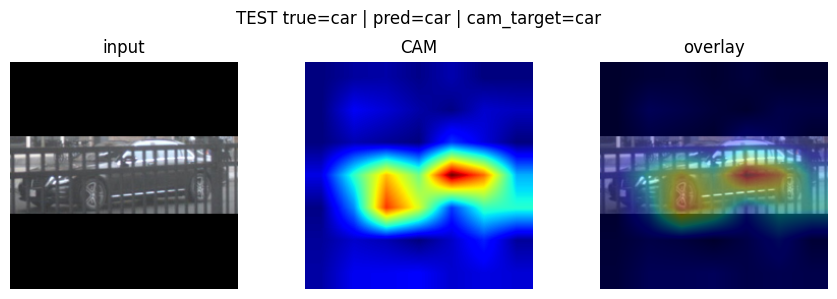

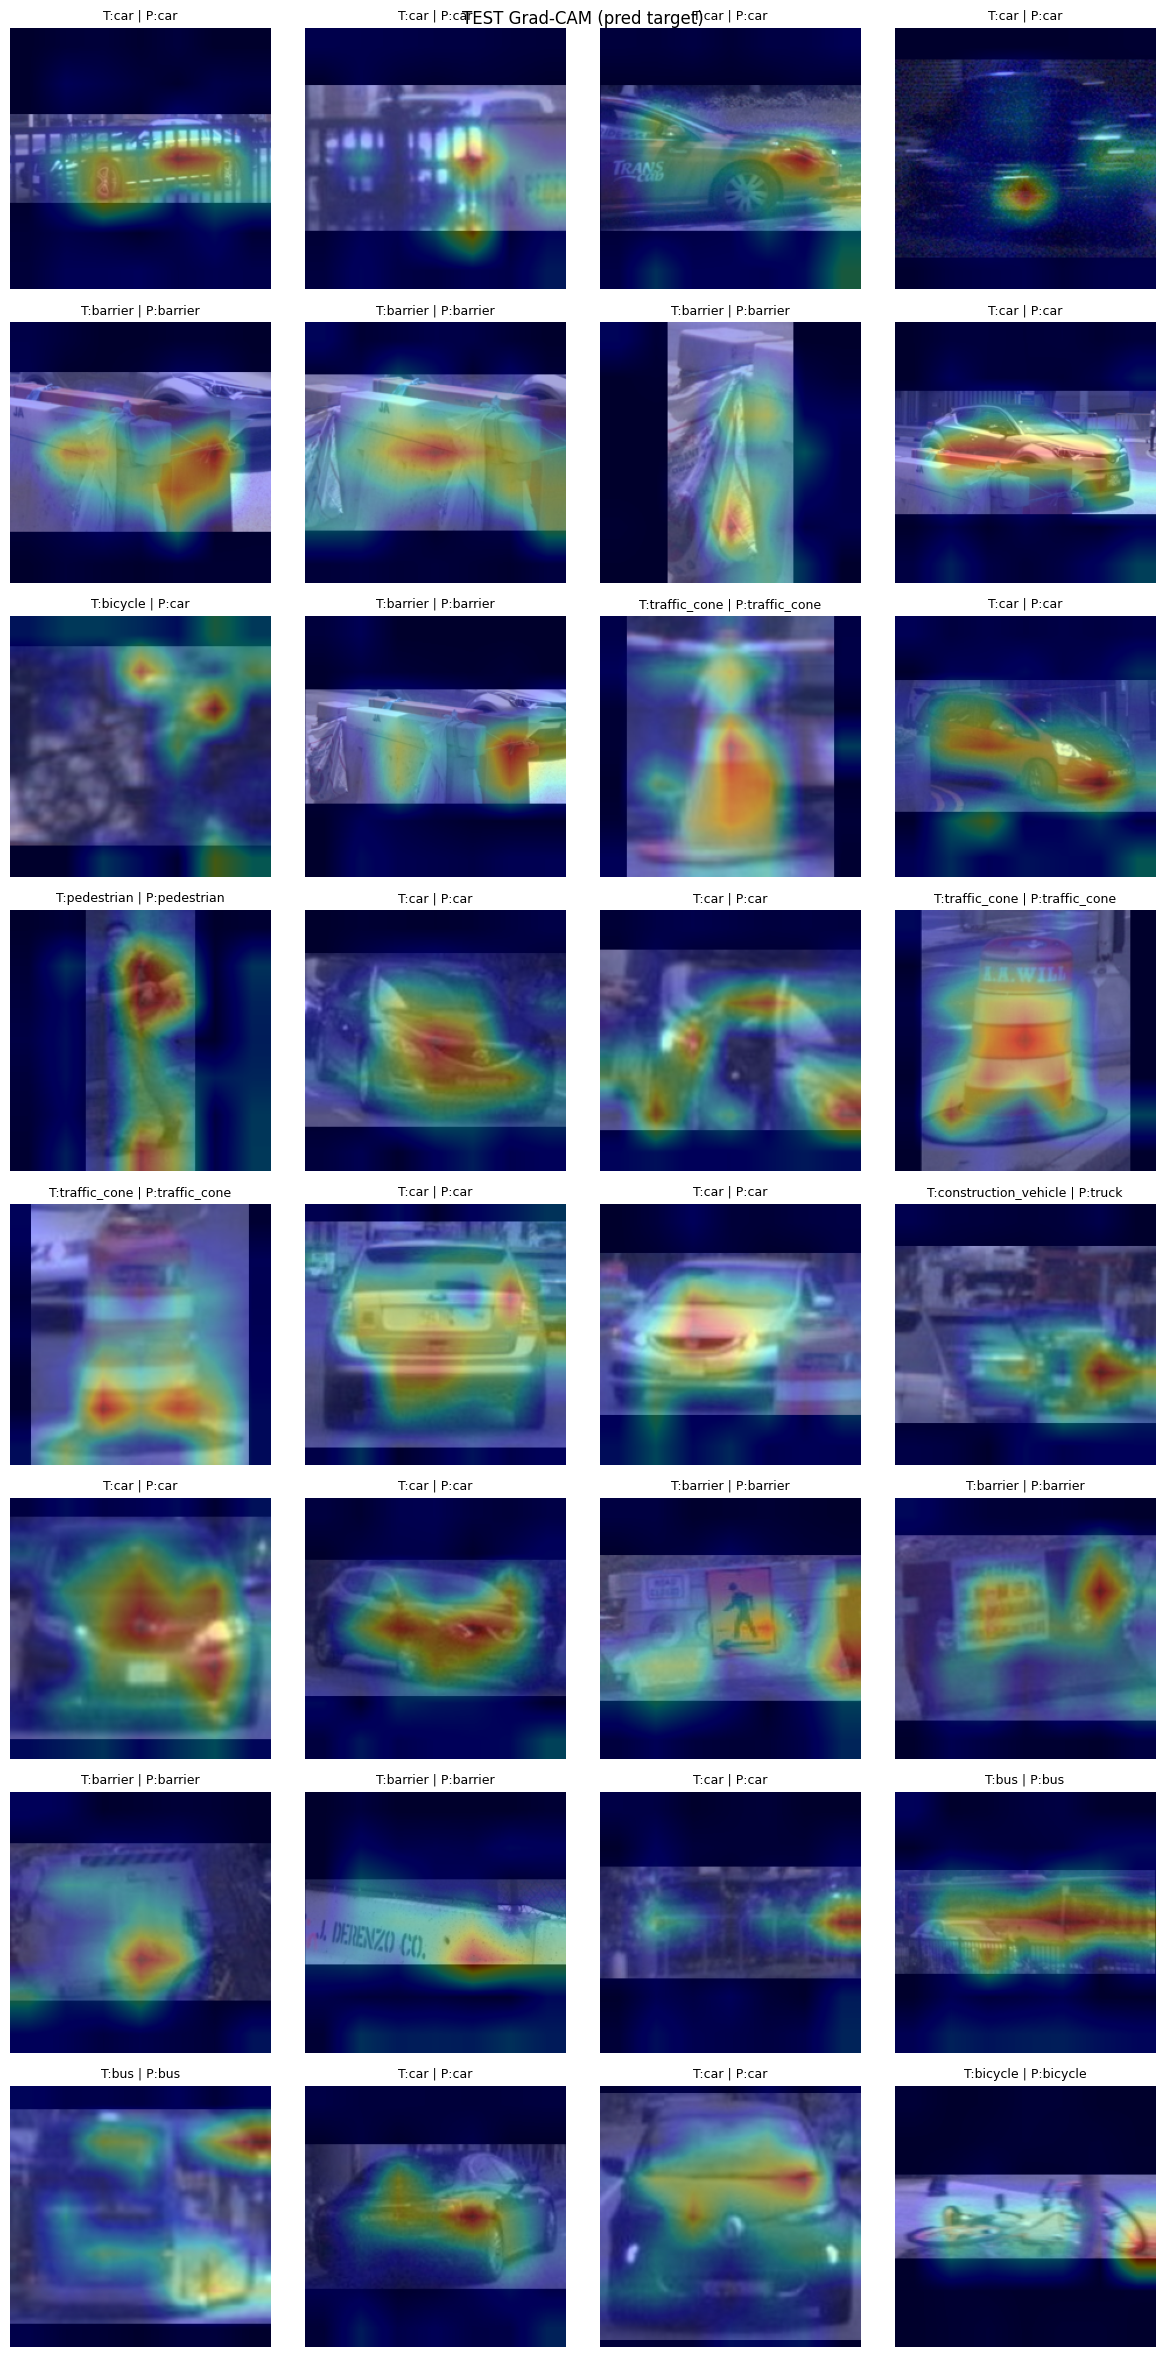

In [36]:
# Single sample from validation set (CAM for the model's own predicted class)
gradcam_sample(test_ds, idx=0, target_class=None, device=DEVICE, title_prefix="TEST")

# CAM targeting a specific class id (e.g., force "trailer")
# gradcam_sample(val_ds, idx=0, target_class=name_to_id["trailer"], device=DEVICE, title_prefix="VAL")

# A small grid from the validation loader
gradcam_batch(test_loader, max_images=32, device=DEVICE, target_class=None, title="TEST Grad-CAM (pred target)")


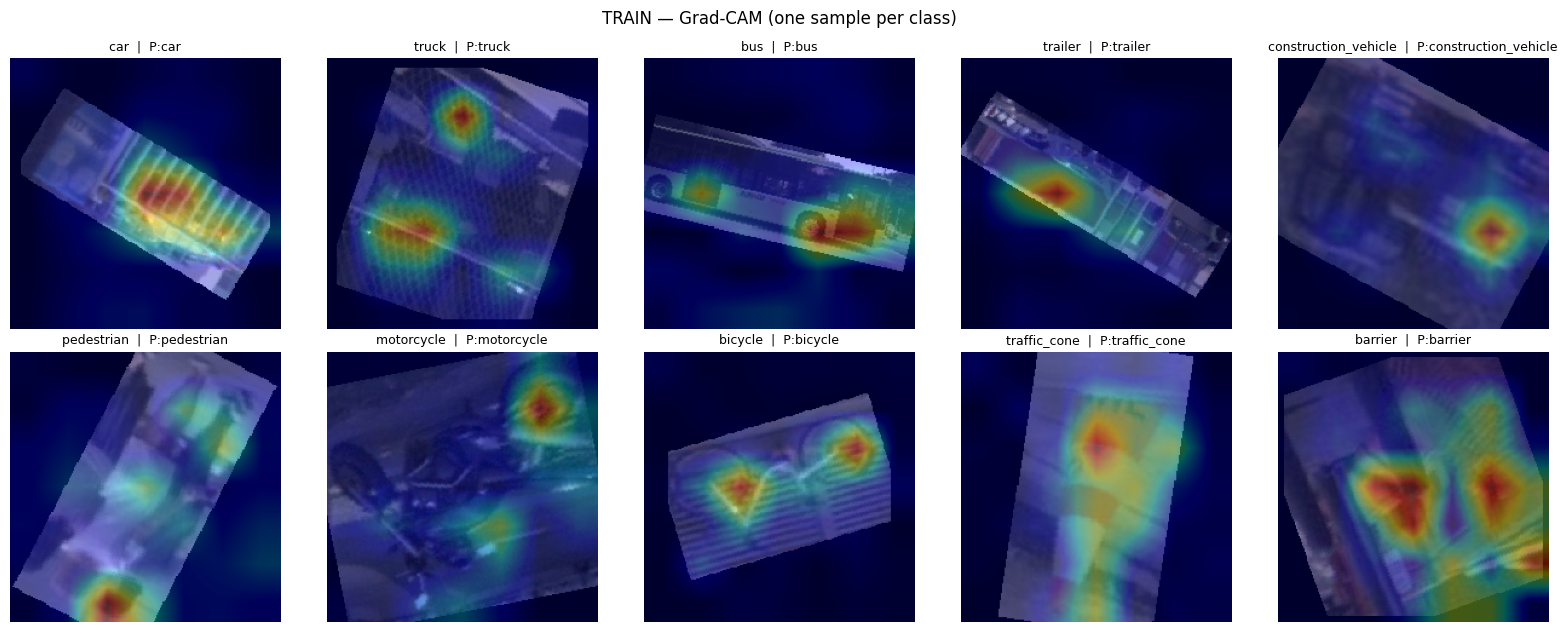

In [35]:
gradcam_one_per_class(
    dataset=train_ds,
    model=model,
    name_to_id=name_to_id,
    device=DEVICE,
    target_layer=model.layer4,   # ResNet-50
    title="TRAIN — Grad-CAM (one sample per class)"
)
